In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd



Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.
*italicised text*
You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

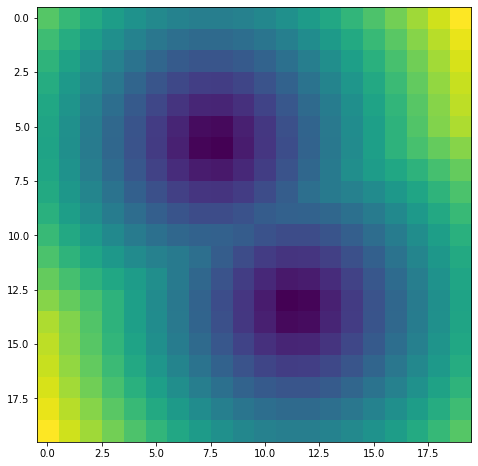


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

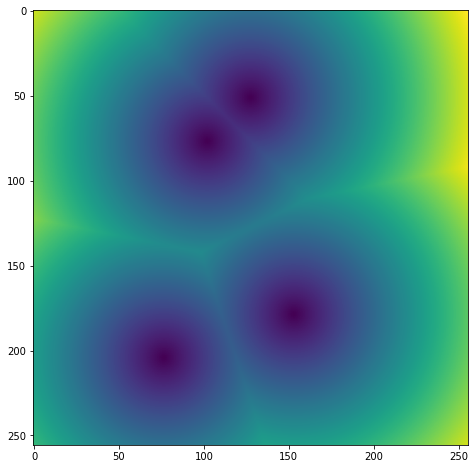


In [4]:
def min_dist(points, res):
  """Calculates a 2D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a python list of 2D coordinates, normalized in the range [0,1]
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points.
  """
  # Convert points to a tensor and scale to [0, res] range
  points_tensor = torch.tensor(points) * res

  # Create a meshgrid of pixel coordinates (scaled to [0, res] range)
  x_coords = torch.arange(res).float().unsqueeze(0).repeat(res, 1)
  y_coords = torch.arange(res).float().unsqueeze(1).repeat(1, res)

  # Stack the coordinates into a grid of shape (res, res, 2)
  grid = torch.stack((x_coords, y_coords), dim=-1)  # Shape: (res, res, 2)

  # Compute the distance from each pixel to each point
  # Expand dimensions of points to allow broadcasting
  points_expanded = points_tensor.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, num_points, 2)
  grid_expanded = grid.unsqueeze(2)  # Shape: (res, res, 1, 2)

  # Compute the Euclidean distances between the grid and the points
  distances = torch.norm(grid_expanded - points_expanded, dim=-1)  # Shape: (res, res, num_points)

  # Take the minimum distance for each pixel
  min_distances = distances.min(dim=-1)[0]  # Shape: (res, res)

  return min_distances

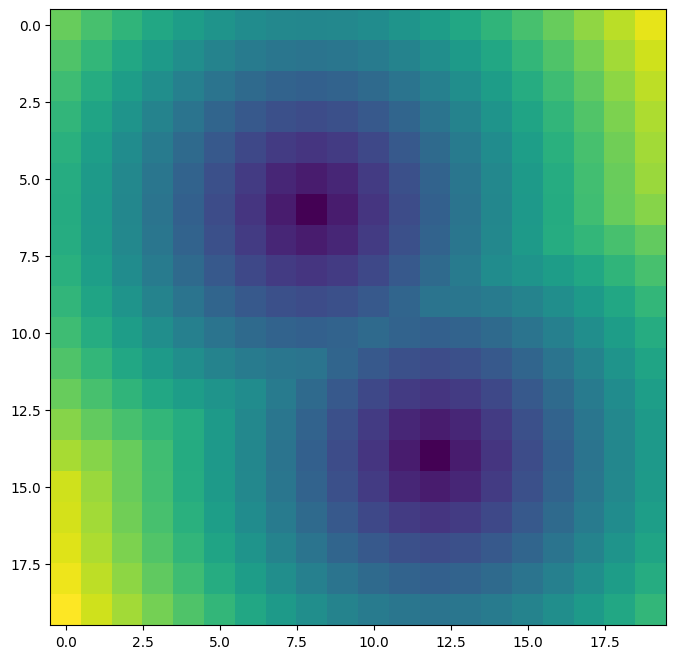

In [5]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

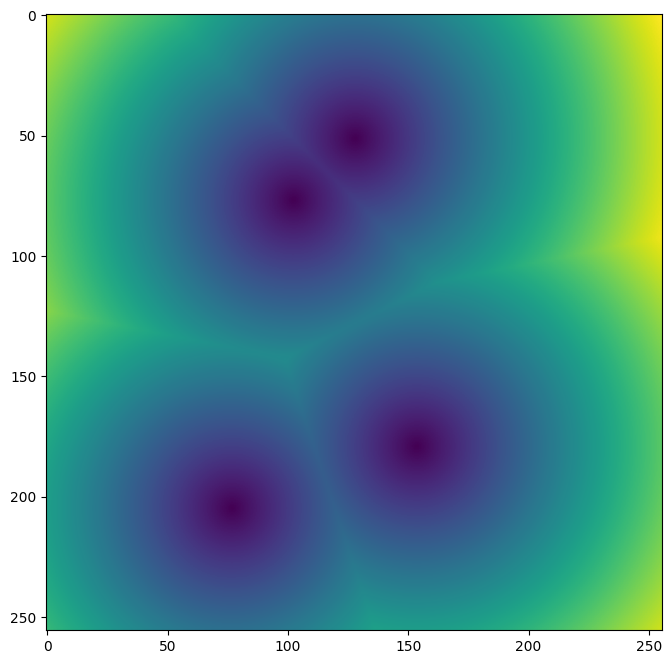

In [6]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

### Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [7]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  values = np.random.randint(0, 10, batch_size*num_points).reshape(batch_size, num_points)
  values = np.expand_dims(values, 2)
  points = np.concatenate((coords, values), axis=2)
  return points

In [8]:
def min_dist(points, res):
  """Calculates a 3D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a numpy array of 2D coordinates and point values, normalized to
              be in the range [0,1]. The expected shape is [B, P, 3].
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].
  """
  # Convert points to tensor if it's not already
  points_tensor = torch.tensor(points, dtype=torch.float32)

  # Generate pixel grid for each batch (each pixel in the grid is in the range [0, res])
  x_coords = torch.arange(res, dtype=torch.float32).unsqueeze(0).repeat(res, 1)
  y_coords = torch.arange(res, dtype=torch.float32).unsqueeze(1).repeat(1, res)

  # Stack the grid to have shape (res, res, 2)
  grid = torch.stack((x_coords, y_coords), dim=-1)  # Shape: [res, res, 2]

  # Expand grid and points to enable broadcasting
  grid_expanded = grid.unsqueeze(0).unsqueeze(2)  # Shape: [1, res, res, 1, 2]
  points_expanded = points_tensor.unsqueeze(1).unsqueeze(3)  # Shape: [B, 1, P, 1, 3]

  # Compute Euclidean distance between grid pixels and each point
  distances = torch.norm(grid_expanded[:, :, :, :, :2] - points_expanded[:, :, :, :, :2], dim=-1)  # Shape: [B, res, res, P]

  # For each pixel, find the minimum distance to the nearest point
  min_distances = distances.min(dim=-1)[0]  # Shape: [B, res, res]

  return min_distances

In [9]:
#Testing the function
batch_size = 3
num_points = 4

#Creating Points
points = create_points(batch_size, num_points)
print(points.shape)
res = 25  #resolution = 25
distances = min_dist(points, res)
print(distances.shape)

(3, 4, 3)
torch.Size([3, 25, 4])


   Input :
  * points: a numpy array of 2D coordinates and point values, normalized to
    be in the range [0,1]. The expected shape is [B, P, 3].
  * res: the resolution of the output tensor.  
   
Returns:  
  * A (res x res) square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].  

While I used the shape [3, P, 3] and res as input and obtained the shape [3, 25, 25] as output which veifies the correctness of the function.


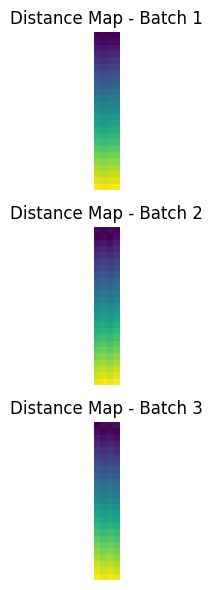

In [10]:
fig, axs = plt.subplots(batch_size, 1, figsize=(6, 6))
for i in range(batch_size):
    axs[i].imshow(distances[i], cmap='viridis')
    axs[i].set_title(f'Distance Map - Batch {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()